In [151]:
import numpy as np
import pandas as pd
train = pd.read_csv('./ml5/train.csv', sep=';', na_values='None')
test = pd.read_csv('./ml5/test.csv', sep=';', na_values='None')

In [152]:
train.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [153]:
test.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,26970.000000,26969.000000,27103.000000
mean,50062.686900,19455.528400,1.353733,164.322267,74.120615,130.271300,95.689000,1.368033,1.222700,0.087838,0.054470,0.805926
std,28906.167148,2477.840922,0.478136,8.213740,14.341540,212.501152,163.852598,0.679166,0.566494,0.283065,0.226947,0.395494
min,5.000000,8865.000000,1.000000,50.000000,10.000000,-130.000000,-90.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,24983.250000,17658.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000
50%,49995.500000,19694.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000
75%,75232.250000,21320.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000
max,99997.000000,23705.000000,2.000000,198.000000,183.000000,16020.000000,9100.000000,3.000000,3.000000,1.000000,1.000000,1.000000


In [154]:
NONE_COLS = ['smoke', 'alco', 'active']
NONE_FRACTION = 0.15
np.random.seed(87342)
for col in NONE_COLS:
    choice = np.random.choice(len(train), int(NONE_FRACTION * len(train)))
    train[col][choice] = None

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [155]:
data = pd.concat([train.drop(['cardio'], 1), test], 0)

In [156]:
from operator import itemgetter
from collections import Counter

def memoize(func):
    mem = {}
    def memoizer(*args, **kwargs):
        key = str(args) + str(kwargs)
        if key not in mem:
            mem[key] = func(*args, **kwargs)
        return mem[key]
    return memoizer

@memoize    
def levenshtein(s, t):
    if s == '':
        return len(t)
    if t == '':
        return len(s)
    if s[-1] == t[-1]:
        cost = 0
    else:
        cost = 1
    
    res = min([levenshtein(s[:-1], t)+1,
               levenshtein(s, t[:-1])+1, 
               levenshtein(s[:-1], t[:-1]) + cost])
    return res

def fix_ap(hi, lo):
    hi = [e // 10 if e >= 1000 and e % 100 == 0 else e for e in map(abs, hi)]
    lo = [e // 10 if e >= 1000 and e % 100 == 0 else e for e in map(abs, lo)]
    
    pairs = Counter(zip(hi, lo)).most_common()
    counter, dict_size = 0, 0
    reference = []
    while counter < 0.99 * len(hi) and dict_size < len(hi):
        if pairs[dict_size][0][0] > pairs[dict_size][0][1]:
            counter += pairs[dict_size][1]
            hi_lo = pairs[dict_size][0]
            reference.append((hi_lo, '%s:%s' % hi_lo))
        dict_size += 1
    
    print(dict_size, counter / len(hi))
    print(reference)

    map_hi_lo = dict((hi_lo, hi_lo) for hi_lo, _ in reference)
    
    for hi_lo, _ in pairs:
        match = min((levenshtein(r[1], '%s:%s' % hi_lo), r[0]) for r in reference)
        map_hi_lo[hi_lo] = match[1]
        
    result = [map_hi_lo[hi_lo] for hi_lo in zip(hi, lo)]
    return list(map(itemgetter(0), result)), list(map(itemgetter(1), result))
        

    
    

In [157]:
ap_hi, ap_lo = fix_ap(data['ap_hi'], data['ap_lo'])
data['ap_hi'] = ap_hi
data['ap_lo'] = ap_lo

917 0.99
[((120, 80), '120:80'), ((140, 90), '140:90'), ((110, 70), '110:70'), ((130, 80), '130:80'), ((130, 90), '130:90'), ((140, 80), '140:80'), ((150, 90), '150:90'), ((110, 80), '110:80'), ((120, 70), '120:70'), ((160, 100), '160:100'), ((150, 100), '150:100'), ((100, 70), '100:70'), ((160, 90), '160:90'), ((140, 100), '140:100'), ((120, 90), '120:90'), ((100, 60), '100:60'), ((90, 60), '90:60'), ((150, 80), '150:80'), ((130, 70), '130:70'), ((120, 60), '120:60'), ((110, 60), '110:60'), ((100, 80), '100:80'), ((180, 100), '180:100'), ((160, 80), '160:80'), ((170, 100), '170:100'), ((110, 90), '110:90'), ((120, 79), '120:79'), ((125, 80), '125:80'), ((130, 100), '130:100'), ((140, 70), '140:70'), ((170, 90), '170:90'), ((160, 110), '160:110'), ((90, 70), '90:70'), ((180, 90), '180:90'), ((145, 90), '145:90'), ((180, 110), '180:110'), ((130, 85), '130:85'), ((150, 110), '150:110'), ((170, 110), '170:110'), ((150, 70), '150:70'), ((135, 80), '135:80'), ((115, 70), '115:70'), ((115, 8

In [158]:
from sklearn.metrics import log_loss
from sklearn.ensemble import GradientBoostingClassifier

LEARNING_RATE = 0.01
MAX_DEPTH = 5
SUBSAMPLE = 0.75
MAX_FEATURES = 0.5
LEAF = 8
N_ESTIMATORS = 718

def fill_none(data):
    ignore_columns = ['id']
    max_count = max(data.count())
    col_count = list(zip(data.columns, data.count().get_values()))
    none_columns = [col for col, count in col_count if count < max_count]
    X = data.drop(none_columns + ignore_columns, 1).as_matrix()
    print(col_count)
    for col in none_columns:
        y = data[col].as_matrix()
        nan_idx = np.isnan(y)
        gb = GradientBoostingClassifier(n_estimators=N_ESTIMATORS, 
                                 learning_rate=LEARNING_RATE,
                                 max_depth=MAX_DEPTH, 
                                 subsample=SUBSAMPLE,
                                 max_features=MAX_FEATURES,
                                 min_samples_leaf=LEAF)
        gb.fit(X[nan_idx == False], y[nan_idx == False])
        print(col, log_loss(y[nan_idx == False], gb.predict_proba(X[nan_idx == False])))
        data[col][nan_idx == True] = gb.predict_proba(X[nan_idx == True])
    return data 

In [159]:
data = fill_none(data)

[('id', 100000), ('age', 100000), ('gender', 100000), ('height', 100000), ('weight', 100000), ('ap_hi', 100000), ('ap_lo', 100000), ('cholesterol', 100000), ('gluc', 100000), ('smoke', 87214), ('alco', 87255), ('active', 87343)]
smoke 0.231730338398


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


alco 0.185326864478
active 0.483488069685


In [160]:
CATEGORY_COLS = ['gender', 'cholesterol', 'gluc']
data = pd.get_dummies(data, columns=CATEGORY_COLS)

In [161]:
data['height_to_weight'] = data['height'] / data['weight']
data['ap_diff'] = data['ap_hi'] - data['ap_lo']
data['ap_ratio'] = data['ap_lo'] / data['ap_hi']
data.describe()

,id,age,height,weight,ap_hi,ap_lo,smoke,alco,active,gender_1,gender_2,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3,height_to_weight,ap_diff,ap_ratio
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000
mean,49999.500000,19464.864590,164.348140,74.180167,128.835960,81.506500,0.140530,0.110670,0.766252,0.649180,0.350820,0.747740,0.137300,0.114960,0.850150,0.074370,0.075480,2.287897,47.32946,0.645285
std,28867.657797,2470.428376,8.211187,14.379494,153.535263,10.082018,0.334384,0.303762,0.399155,0.477229,0.477229,0.434312,0.344166,0.318975,0.356926,0.262373,0.264166,0.409294,153.06387,0.059419
min,0.000000,8865.000000,50.000000,10.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.316940,2.00000,0.000000
25%,24999.750000,17662.000000,159.000000,65.000000,120.000000,80.000000,0.000000,0.000000,0.793578,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.012987,40.00000,0.615385
50%,49999.500000,19700.000000,165.000000,72.000000,120.000000,80.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.293333,40.00000,0.666667
75%,74999.250000,21324.000000,170.000000,82.000000,140.000000,90.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.538462,50.00000,0.666667
max,99999.000000,23713.000000,250.000000,200.000000,16020.000000,182.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,16.900000,15940.00000,0.980000


In [162]:
train = data.merge(train.loc[:,['id','cardio']], on=['id'])
test = data.merge(test.loc[:,['id']], on=['id'])

In [163]:
train.to_csv('train_.tsv', '\t')
test.to_csv('test_.tsv', '\t')

In [164]:
X_train = train.drop(['cardio', 'id'], 1).as_matrix()
y_train = train['cardio'].as_matrix()
X_test = test.drop(['id'], 1).as_matrix()

In [193]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# 0.577329283214
# 0.58009529054
# 0.576594181237
# 0.575518196677

#0.560638833189
#0.56690827324
#0.565880554625
#0.558810237243


NUMERIC_COLS = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'height_to_weight', 'ap_diff', 'ap_ratio']

data.loc[:, NUMERIC_COLS] = (data.loc[:, NUMERIC_COLS] - data.loc[:, NUMERIC_COLS].mean()) \
                             / data.loc[:, NUMERIC_COLS].std()

df_train_ = data.merge(train.loc[:,['id','cardio']], on=['id'])
df_test_ = data.merge(test.loc[:,['id']], on=['id'])

X_train_ = df_train_.drop(['cardio', 'id'], 1).as_matrix()
X_test_ = df_test_.drop(['id'], 1).as_matrix()

X_train_proba_logreg = np.zeros_like(y_train, dtype=np.float32)

logreg = LogisticRegression(C=100)
stratified = StratifiedKFold(n_splits=4, shuffle=True, random_state=13821)
for train_index, test_index in stratified.split(X_train_, y_train):
    logreg.fit(X_train_[train_index,:], y_train[train_index])
    X_train_proba_logreg[test_index] = logreg.predict_proba(X_train_[test_index,:])[:,1]
    print(log_loss(y_train[test_index], [max(1e-12, min(1.-1e-12, e)) for e in X_train_proba_logreg[test_index]]))

logreg.fit(X_train_, y_train)
X_test_proba_logreg = logreg.predict_proba(X_test_)[:,1]

X_train_logreg = np.column_stack((X_train, X_train_proba_logreg))
X_test_logreg = np.column_stack((X_test, X_test_proba_logreg))


X_weight = np.zeros_like(y_train, dtype=np.float32)

kfold = KFold(n_splits=4, shuffle=True, random_state=3419512)
for train_index, test_index in kfold.split(X_train_, [0]*len(X_train)):
    clf = LogisticRegression(C=100)
    X = np.vstack([X_train_[train_index], X_test_])
    y = [0] * len(X_train_[train_index]) + [1] * len(X_test_)
    clf.fit(X, y)
    X_weight[test_index] = clf.predict_proba(X_train_[test_index])[:,1]

0.559966606308
0.567460559812
0.562885493956
0.558825198533


In [166]:
from sklearn.ensemble import GradientBoostingClassifier

LEARNING_RATE = 0.05
MAX_DEPTH = 5
SUBSAMPLE = 0.75
MAX_FEATURES = 0.5
LEAF = 8
N_ESTIMATORS = 120

# 0.537393660189
# 0.540224990743
# 0.54374520056
# 0.537955373991

# 0.536985924234
# 0.539724269209
# 0.54363649945
# 0.538452420793

# 0.539974945211
# 0.543183537273
# 0.547672279472
# 0.54227076643

X_train_proba_gb = np.zeros_like(y_train, dtype=np.float32)

gb = GradientBoostingClassifier(n_estimators=N_ESTIMATORS, 
                                 learning_rate=LEARNING_RATE,
                                 max_depth=MAX_DEPTH, 
                                 subsample=SUBSAMPLE,
                                 max_features=MAX_FEATURES,
                                 min_samples_leaf=LEAF)

stratified = StratifiedKFold(n_splits=4, shuffle=True, random_state=92343)
for train_index, test_index in stratified.split(X_train_logreg, y_train):
    gb.fit(X_train_logreg[train_index,:], y_train[train_index], sample_weight=X_weight[train_index])
    X_train_proba_gb[test_index] = gb.predict_proba(X_train_logreg[test_index,:])[:,1]
    print(log_loss(y_train[test_index], X_train_proba_gb[test_index]))

gb.fit(X_train_logreg, y_train, sample_weight=X_weight)
X_test_proba_gb = gb.predict_proba(X_test_logreg)[:,1]

0.537734633039
0.54084066701
0.544774464519
0.539460073504


In [167]:
from sklearn.ensemble import RandomForestClassifier


LEAF = 24
N_ESTIMATORS = 195


# 0.53721941118
# 0.545754740511
# 0.541656026029
# 0.539694171679

# 0.537595501441
# 0.545116374224
# 0.541802491798
# 0.539919672545


X_train_proba_rf = np.zeros_like(y_train, dtype=np.float32)

rf = RandomForestClassifier(n_estimators=N_ESTIMATORS,
                            min_samples_leaf=LEAF)

stratified = StratifiedKFold(n_splits=4, shuffle=True, random_state=18134)
for train_index, test_index in stratified.split(X_train_logreg, y_train):
    rf.fit(X_train_logreg[train_index,:], y_train[train_index], sample_weight=X_weight[train_index])
    y_pred = rf.predict_proba(X_train_logreg[test_index,:])
    X_train_proba_rf[test_index] = y_pred[:,1]
    print(log_loss(y_train[test_index], X_train_proba_rf[test_index]))

rf.fit(X_train_logreg, y_train, sample_weight=X_weight)
X_test_proba_rf = rf.predict_proba(X_test_logreg)[:,1]

0.538315868728
0.546390919952
0.543279467355
0.540995008597


169 0.536552234024


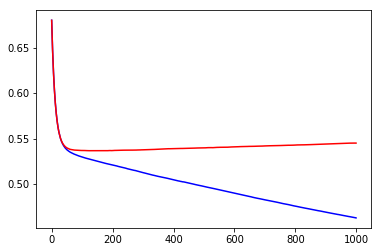

In [798]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train_logreg, 
                                                        y_train,
                                                        test_size=0.33, 
                                                        random_state=42)

LEARNING_RATE = 0.05
MAX_DEPTH = 5
SUBSAMPLE = 0.75
MAX_FEATURES = 0.5
LEAF = 8 # 818 0.536890801542

clf = GradientBoostingClassifier(n_estimators=1000, 
                                 learning_rate=LEARNING_RATE,
                                 max_depth=MAX_DEPTH, 
                                 subsample=SUBSAMPLE,
                                 max_features=MAX_FEATURES,
                                 min_samples_leaf=LEAF)

clf.fit(X_train_, y_train_)

test_score = np.zeros((clf.n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(clf.staged_predict_proba(X_test_)):
    test_score[i] = log_loss(y_test_, y_pred)
    
train_score = np.zeros((clf.n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(clf.staged_predict_proba(X_train_)):
    train_score[i] = log_loss(y_train_, y_pred)
    
print(np.argmin(test_score), np.min(test_score))
plt.plot(range(len(train_score)), train_score, 'b-',
         range(len(test_score)), test_score, 'r-')

290 0.538218665554


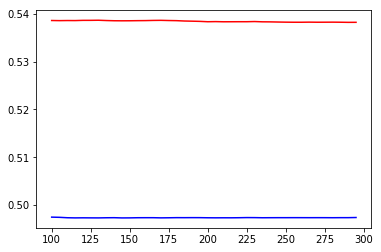

In [797]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train_logreg, 
                                                        y_train,
                                                        test_size=0.33, 
                                                        random_state=54)

LEAF = 24 
# 550 8 0.540
# 80  32 0.539426191726
# 110 24 0.53932580292

clf = RandomForestClassifier(min_samples_leaf=LEAF,
                             warm_start=True,
                             n_jobs=3)

test_score = []
train_score = []

MIN_ESTIMATORS = 100
MAX_ESTIMATORS = 300

RANGE = list(range(MIN_ESTIMATORS,MAX_ESTIMATORS,5))

for i in RANGE:
    clf.set_params(n_estimators=i)
    clf.fit(X_train_, y_train_)
    y_test_pred = clf.predict_proba(X_test_)
    y_train_pred = clf.predict_proba(X_train_)
    test_score.append(log_loss(y_test_, y_test_pred))
    train_score.append(log_loss(y_train_, y_train_pred))

print(RANGE[np.argmin(test_score)], np.min(test_score))
plt.plot(RANGE, train_score, 'b-',
         RANGE, test_score, 'r-')

In [194]:
X_train_stacked = np.column_stack((X_train_, X_train_proba_logreg, X_train_proba_gb, X_train_proba_rf))
X_test_stacked = np.column_stack((X_test_, X_test_proba_logreg, X_test_proba_gb, X_test_proba_rf))

In [196]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

scoring = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
kfold = KFold(n_splits=4, shuffle=True, random_state=34512)
param_grid = {'C': [1, 10, 100, 1000], 'penalty': ['l1']}

grid = GridSearchCV(LogisticRegression(max_iter=500,
                                       class_weight='balanced'), 
                                       param_grid,
                                       scoring,
                                       cv=kfold)

grid.fit(X_train_stacked, y_train)

y_test = grid.best_estimator_.predict_proba(X_test_stacked)
y_test = y_test[:,1]

pd.DataFrame(grid.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_penalty,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,12.765978,0.006132,-0.541263,-0.540907,1,l1,"{'penalty': 'l1', 'C': 1}",3,-0.542202,-0.540566,-0.541632,-0.540783,-0.540614,-0.541157,-0.540605,-0.541122,4.880253,0.000165,0.000684,0.000245
1,3.941007,0.006024,-0.541264,-0.540906,10,l1,"{'penalty': 'l1', 'C': 10}",4,-0.542201,-0.540564,-0.541635,-0.540783,-0.540624,-0.541156,-0.540595,-0.541121,0.102382,0.000127,0.000684,0.000245
2,3.671370,0.006508,-0.541263,-0.540906,100,l1,"{'penalty': 'l1', 'C': 100}",2,-0.542202,-0.540564,-0.541634,-0.540783,-0.540625,-0.541156,-0.540592,-0.541121,0.059650,0.000690,0.000685,0.000245
3,4.485851,0.006028,-0.541263,-0.540906,1000,l1,"{'penalty': 'l1', 'C': 1000}",1,-0.542195,-0.540564,-0.541635,-0.540783,-0.540625,-0.541156,-0.540596,-0.541122,0.619989,0.000117,0.000682,0.000246


In [197]:
grid.best_estimator_.coef_

array([[ 0.12129608,  0.01229814,  0.00650047, -0.54793423,  0.30817519,
        -0.0400772 , -0.04299587, -0.05812896, -0.23438704, -0.25532507,
        -0.8020991 , -0.66647127, -0.46004472, -0.20066617, -0.21177939,
        -0.38363658, -0.04949381,  0.52370243, -0.18626931, -1.84612491,
         3.37551576,  1.80243958]])

In [200]:
import sys
sys.path.append('/Users/vmurashkin/Projects/netology/000-sklearn/xgboost/python-package')

import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# 0.537957597018
# 0.539590006401

X_train_, X_test_, y_train_, y_test_, W_train_, W_test_ = train_test_split(X_train_stacked, 
                                                        y_train,
                                                        X_weight,
                                                        test_size=0.33, 
                                                        random_state=43285192)

LERANING_RATE = 0.075
MIN_CHILD_WEIGHT = 64
MAX_DEPTH = 6
SUBSAMPLE = 0.75
BY_TREE = 0.8


xgb = XGBClassifier(n_estimators=1000,
                    learning_rate=LERANING_RATE, 
                    min_child_weight=MIN_CHILD_WEIGHT,
                    max_depth=MAX_DEPTH,
                    subsample=SUBSAMPLE, 
                    colsample_bytree=BY_TREE,
                    silent=True)

xgb.fit(X_train_, y_train_,
        eval_set=[(X_train_, y_train_), (X_test_, y_test_),],
        eval_metric='logloss', 
        early_stopping_rounds=10)

print(log_loss(y_train_, xgb.predict_proba(X_train_)))
print(log_loss(y_test_, xgb.predict_proba(X_test_)))


xgb = XGBClassifier(n_estimators=xgb.best_iteration,
                    learning_rate=LERANING_RATE, 
                    min_child_weight=MIN_CHILD_WEIGHT,
                    max_depth=MAX_DEPTH,
                    subsample=SUBSAMPLE, 
                    colsample_bytree=BY_TREE,
                    silent=True)


xgb.fit(X_train_logreg, y_train)

X_test_proba_xgb = xgb.predict_proba(X_test_logreg)[:,1]

[0]	validation_0-logloss:0.672992	validation_1-logloss:0.673069
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.655572	validation_1-logloss:0.65568
[2]	validation_0-logloss:0.640406	validation_1-logloss:0.640604
[3]	validation_0-logloss:0.627443	validation_1-logloss:0.627713
[4]	validation_0-logloss:0.616236	validation_1-logloss:0.616572
[5]	validation_0-logloss:0.606451	validation_1-logloss:0.606892
[6]	validation_0-logloss:0.597835	validation_1-logloss:0.598417
[7]	validation_0-logloss:0.590266	validation_1-logloss:0.590935
[8]	validation_0-logloss:0.583715	validation_1-logloss:0.584508
[9]	validation_0-logloss:0.577809	validation_1-logloss:0.57874
[10]	validation_0-logloss:0.57259	validation_1-logloss:0.573633
[11]	validation_0-logloss:0.568131	validation_1-logloss:0.569298
[12]	validation_0-logloss:0.564192	validation_1-logloss:0.565473
[13

In [184]:
y_test = np.power(X_test_proba_gb * X_test_proba_rf * X_test_proba_xgb, 1/3)
y_test = X_test_proba_xgb

In [198]:
with open('submission.txt', 'w') as dst:
    dst.writelines('%s\n' % y for y in y_test)

In [199]:
!head ./submission.txt

0.478741260568
0.448059461318
0.412108690227
0.530594763693
0.20395766263
0.245101739313
0.189566917555
0.378119487879
0.251552237144
0.894173693324


In [694]:
!head /Users/vmurashkin/Downloads/submission.txt

0.497684635242
0.573637497798
0.372767200332
0.55355291323
0.227121019345
0.252056829349
0.187007340157
0.374298622103
0.27347270647
0.869167034374
